# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

In [ ]:
# os.chdir("/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data")

In [3]:
os.chdir("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data")

# Import Packages Required

In [4]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Softmax, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow
import pandas as pd

%matplotlib inline
from glob import glob

In [5]:
# Set seed
seed(1)
tensorflow.random.set_seed(2)

# Get File Directory & Function

In [6]:
# train_data_dir = '/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/train'
# test_data_dir = '/content/drive/MyDrive/AY21_22/2021/BT4221/BT4221 Project/Processing   Model /Data/test'
train_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/train'
test_data_dir = '/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/test'

# train_data_dir = "/content/drive/My Drive/Data/train"
# test_data_dir = "/content/drive/My Drive/Data/test"

Pneumona_img = os.listdir(train_data_dir + "/PNEUMONIA")
Normal_img = os.listdir(train_data_dir + "/NORMAL")
COVID19_img = os.listdir(train_data_dir + "/COVID19")

In [7]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

# Preprocessing (Img Aug)

In [8]:
# To Tackle Issue of Imbalanced Dataset during Model Fitting
pneumonia_cases = len(Pneumona_img)
normal_cases = len(Normal_img)
covid_cases = len(COVID19_img)

pneumonia_weight = pneumonia_cases / (pneumonia_cases + normal_cases + covid_cases)
normal_weight = normal_cases / (pneumonia_cases + normal_cases + covid_cases)
covid_weight = covid_cases / (pneumonia_cases + normal_cases + covid_cases)

class_weight = {0: covid_weight, 1: normal_weight,
                2: pneumonia_weight}

print(f"Weight for class 0: {covid_weight:.2f}")
print(f"Weight for class 1: {normal_weight:.2f}")
print(f"Weight for class 2: {pneumonia_weight:.2f}")

Weight for class 0: 0.22
Weight for class 1: 0.21
Weight for class 2: 0.57


In [9]:
img_size = [224, 224]
train_datagen = ImageDataGenerator(rescale = 1./224,
                                   rotation_range=140,
                                   width_shift_range=0.1,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale = 1./224)

train_generator = train_datagen.flow_from_directory(directory = train_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 8,
                                                        shuffle = True,
                                                        class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(directory = test_data_dir,
                                                        target_size = tuple(img_size),
                                                        batch_size = 1,
                                                        class_mode = 'categorical',
                                                        shuffle = False)

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# VGG Set Up

In [10]:
baseModel = VGG16(input_shape = img_size + [3], weights='imagenet', include_top=False)
for layer in baseModel.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


# 0 Dropout Layer

## Original Neuron Number

In [11]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 128, activation = 'relu')(model)
model = Dense(units = 64, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [13]:
CheckPointCallback = ModelCheckpoint("vgg_testaug.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [14]:
seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1559s 2s/step - loss: 0.1437 - accuracy: 0.8079 - val_loss: 0.4842 - val_accuracy: 0.7609

Epoch 00001: val_accuracy improved from -inf to 0.76087, saving model to vgg_testaug.h5
Epoch 2/25
755/755 [==============================] - 302s 400ms/step - loss: 0.0961 - accuracy: 0.8672 - val_loss: 0.1833 - val_accuracy: 0.9301

Epoch 00002: val_accuracy improved from 0.76087 to 0.93012, saving model to vgg_testaug.h5
Epoch 3/25
755/755 [==============================] - 299s 396ms/step - loss: 0.0830 - accuracy: 0.8923 - val_loss: 0.2664 - val_accuracy: 0.8975

Epoch 00003: val_accuracy did not improve from 0.93012
Epoch 4/25
755/755 [==============================] - 295s 390ms/step - loss: 0.0744 - accuracy: 0.9014 - val_loss: 0.3082 - val_accuracy: 0.8641

Epoch 00004: val_accuracy did not improve from 0.93012
Epoch 5/25
755/755 [==============================] - 298s 395ms/step - loss: 0.0773 - accuracy: 0.8992 - val_loss: 0.1961 - 

In [15]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

1288/1288 [==============================] - 59s 45ms/step - loss: 0.1503 - accuracy: 0.9441
Test Accuracy: 94.41%
755/755 [==============================] - 252s 333ms/step - loss: 0.2340 - accuracy: 0.8959
Train Accuracy: 89.59%


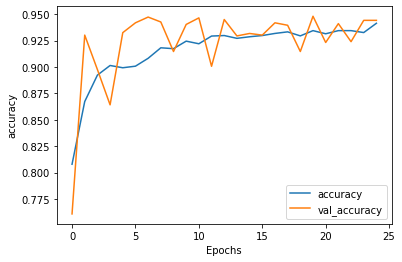

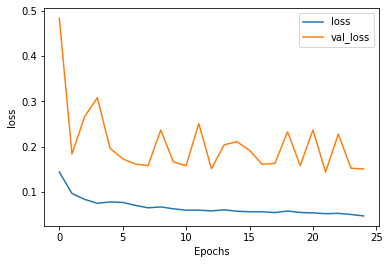

In [16]:
plotting(history, "accuracy")
plotting(history, "loss")

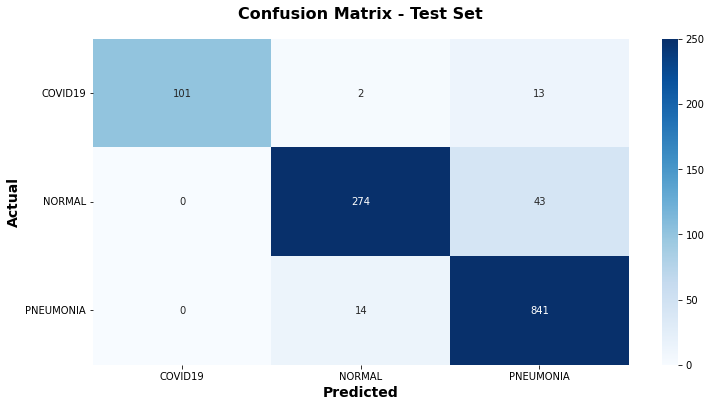

In [17]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

## All Same Num of Neurons

In [ ]:
model =  MaxPooling2D(pool_size = (2, 2), 
                               strides = 1, padding = 'valid')(baseModel.output)
model = Flatten()(model)

model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 256, activation = 'relu')(model)
model = Dense(units = 256, activation = 'relu')(model)


# Stick with 3 because 3 different classes to be predicted
predictions = Dense(units = 3, activation = 'softmax')(model)
model = Model(inputs = baseModel.input, outputs = predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
opt = Adam(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
CheckPointCallback = ModelCheckpoint("vgg_imgaug.h5", monitor='val_accuracy',save_best_only=True, mode='max',verbose=1)

In [ ]:
seed(1)
tensorflow.random.set_seed(2)

history = model.fit(train_generator,
                    epochs = 25,
                    batch_size = 16,
                    validation_data= test_generator,
                    class_weight = class_weight,
                    callbacks = [CheckPointCallback],
                    verbose = 1)

Epoch 1/25
755/755 [==============================] - 1767s 2s/step - loss: 0.1413 - accuracy: 0.8081 - val_loss: 0.2489 - val_accuracy: 0.9068

Epoch 00001: val_accuracy improved from -inf to 0.90683, saving model to vgg_imgaug.h5
Epoch 2/25
755/755 [==============================] - 300s 398ms/step - loss: 0.0887 - accuracy: 0.8807 - val_loss: 0.2639 - val_accuracy: 0.8967

Epoch 00002: val_accuracy did not improve from 0.90683
Epoch 3/25
755/755 [==============================] - 299s 397ms/step - loss: 0.0786 - accuracy: 0.8991 - val_loss: 0.3553 - val_accuracy: 0.8393

Epoch 00003: val_accuracy did not improve from 0.90683
Epoch 4/25
755/755 [==============================] - 304s 403ms/step - loss: 0.0781 - accuracy: 0.8974 - val_loss: 0.1510 - val_accuracy: 0.9433

Epoch 00004: val_accuracy improved from 0.90683 to 0.94332, saving model to vgg_imgaug.h5
Epoch 5/25
755/755 [==============================] - 307s 407ms/step - loss: 0.0713 - accuracy: 0.9105 - val_loss: 0.1371 - va

In [ ]:
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")


1288/1288 [==============================] - 58s 45ms/step - loss: 0.1470 - accuracy: 0.9503
Test Accuracy: 95.03%
755/755 [==============================] - 233s 308ms/step - loss: 0.1914 - accuracy: 0.9274
Train Accuracy: 92.74%


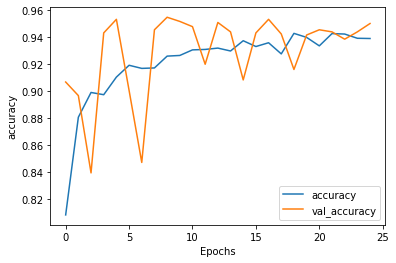

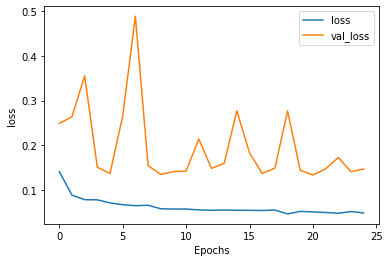

In [ ]:
plotting(history, "accuracy")
plotting(history, "loss")

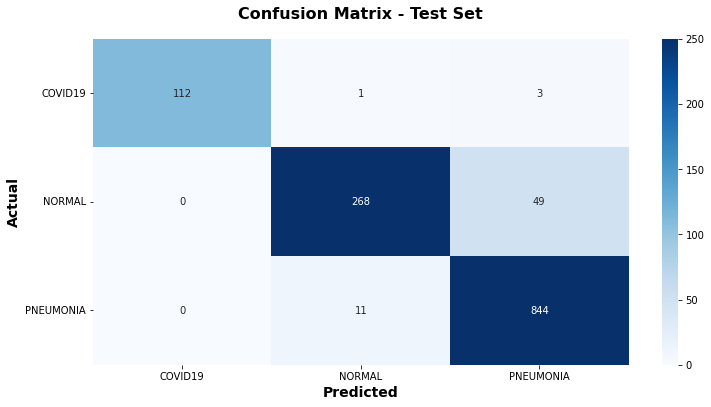

In [ ]:
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

# Heat Map

In [ ]:
#!pwd
os.chdir("/content/drive/My Drive/Data/vizgradcam")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)

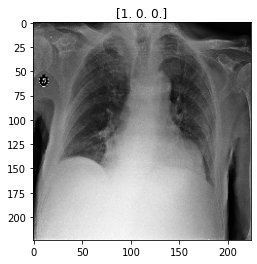

In [ ]:
test_img = test_generator.__getitem__(1)
preview_imgs, preview_labels = test_img
plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

img = preview_imgs[0]
img.shape

In [ ]:
os.chdir("/content/drive/MyDrive/BT4221 Project/Processing   Model /Data/vizgradcam")

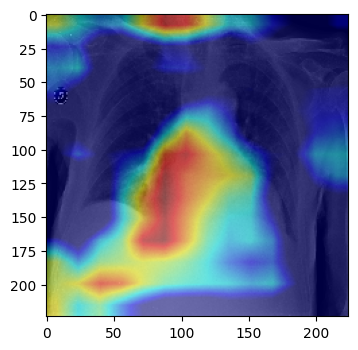

In [ ]:
from gradcam import VizGradCAM

VizGradCAM(
    model,   #load model   (this is your model)
    img
)

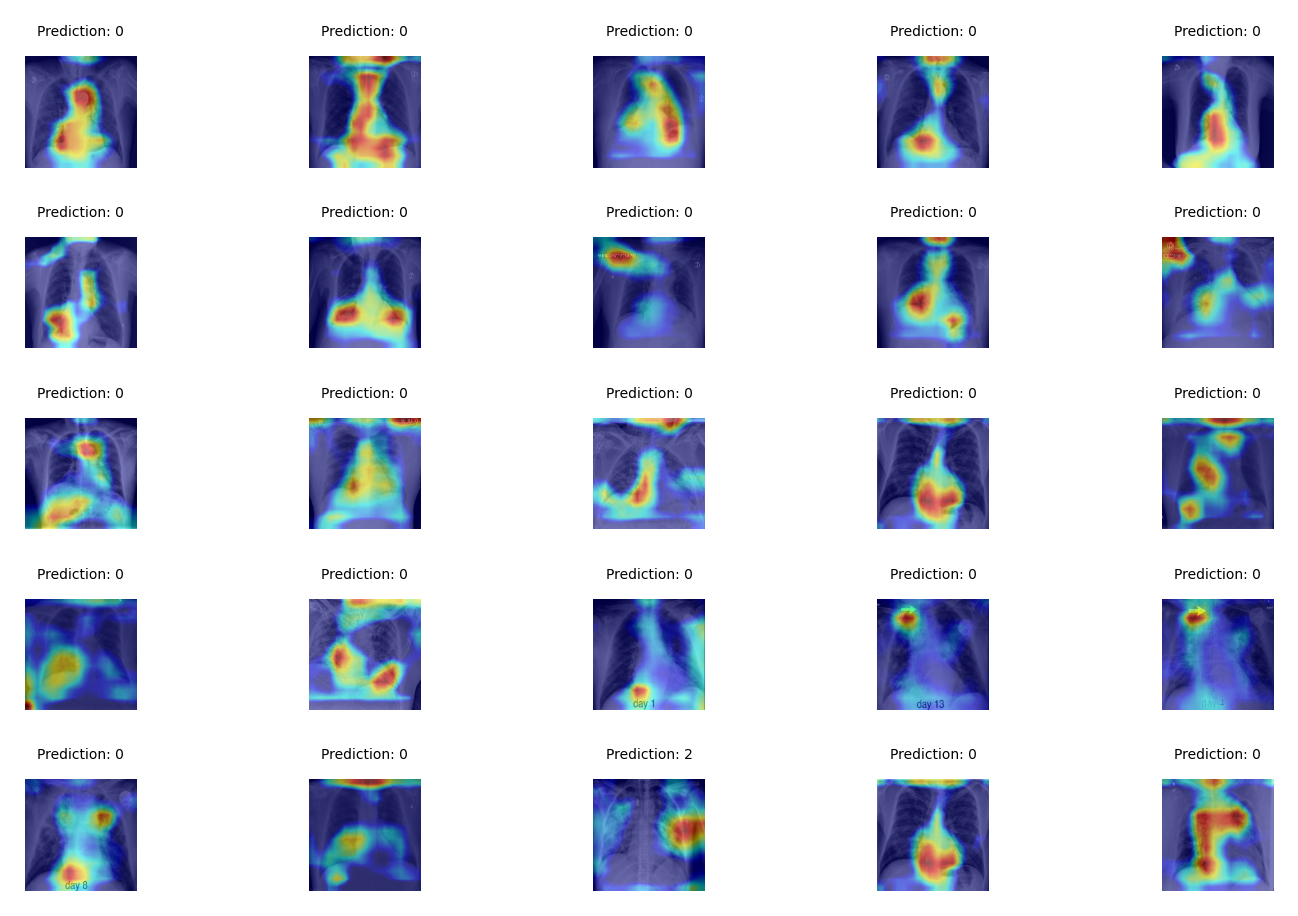

In [ ]:
for i in range(25):
  # define subplot
  plt.rcParams["figure.dpi"] = 250
  plt.subplot(5,5, i+1)
  plt.tight_layout()
  img = test_generator.__getitem__(i+25)
  preview_img, preview_labels = img
  pred = model.predict(preview_img[0].reshape(1, 224, 224, 3))
  plt.title("Prediction: " + str(pred.argmax()),fontsize = 4)
  plt.axis('off')
  VizGradCAM(model, preview_img[0])